# Implementation of the article on Poincarré Embeddings 

In [6]:
# Packages import 

import numpy as np
from numpy.linalg import norm
from math import *
import matplotlib.pyplot as plt
import random
import nltk
nltk.download('wordnet')  
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/charlesdognin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## I Preprocessing

But : 
- Partir d'un mot wordnet.synset("mot")
- Construire un dictionnaire représentant le graphe lié à ce mot, du type {"mot" : [liste des hyponymes]}
- Construire un dictionnaire du type {"mot" : niveau du mot}
- Construire un dictionnaire des mots embedded du type {"mot" : vecteur}

Dans le dictionnaire représentant le graphe, un même mot peut être clé ou valeur.
Dans le dictionnaire des mots embedded, chaque mot est unique.

In [7]:
# Choose a source word for our graph, here the word "mammal", whose level in the graph is 0 (by default)

mammal = wordnet.synset("mammal.n.01")
print(mammal.definition())  # definition of "mammal"
print('-------------------------')
print(mammal)

any warm-blooded vertebrate having the skin more or less covered with hair; young are born alive except for the small subclass of monotremes and nourished with milk
-------------------------
Synset('mammal.n.01')


In [8]:
# Hyponyms of the source word, i.e. its direct children in the graph
mammal.hyponyms()

[Synset('female_mammal.n.01'),
 Synset('fossorial_mammal.n.01'),
 Synset('metatherian.n.01'),
 Synset('placental.n.01'),
 Synset('prototherian.n.01'),
 Synset('tusker.n.01')]

## II Training of the Embeddings

In [91]:
class Poincarre_Embeddings:
    
    def __init__(self, epochs, learning_rate, nb_negs, root_node, dimension):
        """
        Object providing the embedding for words related by hypermnemy relations using 
        hyperbolic geometry.
        
        Arguments:
        
        epochs -- number of epochs/iterations
        learning_rate -- the learning rate for update of the embedding
        nb_negs -- number of negative samples
        root_node -- the higher word in the hierarchy, the format must be: wordnet.synset("word.n.01")
        dimension -- the embedding dimension
        """
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.nb_negs = nb_negs
        self.root_node = root_node
        self.dimension = dimension
        
    # Sample graph as a dictionnary

    def sample_graph(self, root_node, max_level=3) :
        """
        Function that samples a hierarchical network from a root node and its hyponyms.
        :param root_node: root node of the network
        :param max_level: (int) maximum level of the network
        :return graph: dictionnary representing the graph {"node" : [hyponyms]}
        :return levels: dictionnary representing the level of each node {"node" : level}
        """

        graph = {}

        # keep track of visited nodes
        explored = []

        # keep track of nodes to be checked
        queue = [root_node]

        levels = {}
        levels[str(root_node)] = 0

        visited = [str(root_node)]

        while queue:

            # take out first node from queue
            node = queue.pop(0)  # node n'est PAS un str

            # condition on maximum level
            if levels[str(node)] == max_level:
                graph[str(node)] = []
                break;

            # mark node as explored node
            explored.append(str(node))  # explored est un str

            # sample neighbours of node (i.e. its hyponyms)
            neighbours = [neighbour for neighbour in node.hyponyms()]  # ce sont pas des str
            neighbours_str = [str(neighbour) for neighbour in node.hyponyms()]

            # add neighbours to the graph (as children of the node)
            graph[str(node)] = neighbours_str

            # add neighbours of node to queue
            for neighbour in neighbours :   # no str
                if str(neighbour) not in visited :
                    queue.append(neighbour) # no str
                    visited.append(str(neighbour))
                    levels[str(neighbour)] = levels[str(node)] + 1

        return graph, levels
    
    def sample_embeddings(self, graph, dimension):
        """
        Initializes embedded vectors of graph.
        :param graph: graph containing words
        :param dimension: (int) dimension of the embedding space
        :return embeddings: dictionnary of the form {"node" : vector}
        """

        embeddings = {}

        for word in graph:
            embeddings[word] = np.random.uniform(low=-0.1, high=0.1, size=(dimension,))

        return embeddings
    
    def create_embeddings(self, dimension, root_node):
        """
        Creates embeddings for words
        """
        graph, levels = self.sample_graph(self.root_node) 
        embeddings = self.sample_embeddings(graph, self.dimension)
        
        return graph, embeddings
        

    def dist(self, u, v):
        """
        Computes the distance for the Poincaré disk model between two vectors u and v

        Arguments:
        u -- first embedded object
        v -- second embedded object

        Returns:
        z -- the ditance between the two objects
        """

        norm2u = norm(u)**2
        norm2v = norm(u)**2
        norm2distuv = norm(u - v)**2
        t = 1 + 2 * (norm2distuv / ((1 - norm2u) * (1 - norm2v)))
        z = np.arccosh(t)
        
        return z

    def pdr(self, theta, x):
        """
        Computes the partial derivative w.r.t theta

        Arguments:
        theta -- embedding of the object
        x -- vector corresponding to the embedding of another object (same dimension as theta)

        Returns:
        partial -- the derivative (same dimension as theta)  
        """

        alpha = 1.0 - norm(theta)**2
        assert len(alpha.shape) == 0
        beta = 1.0 - norm(x)**2
        assert len(beta.shape) == 0
        gamma = 1 + (2 / (alpha * beta)) * norm(alpha - x)**2
        assert len(gamma.shape) == 0
        assert gamma**2 - 1 >= 0
        partial = 4.0 / (beta * np.sqrt(gamma**2 - 1)) * (((norm(x) - 2 * np.dot(theta, x) + 1) / alpha**2) * theta - (x / alpha))

        return partial

    def proj(self, theta, epsilon=1e-5):
        """
        Projection in the Poincaré disk ball

        Parameters:
        theta --  embedding of the object
        epsilon -- scalar (for stability)

        Returns:
        theta -- after projection
        """

        if norm(theta) >= 1:
            theta = (theta / norm(theta)) - epsilon

        return theta

    def update(self, theta, grad, learning_rate):
        """
        Computes the full update for a single embedding of theta

        Parameters:
        theta -- current embedding of the object
        grad -- gradient of the loss function 
        learning_rate -- the learning rate 

        Returns:
        theta -- the updated theta
        """

        upd = (learning_rate / 4) * (1 - norm(theta)**2)**2 * grad
        theta = self.proj(theta - upd)
        assert theta.shape == upd.shape

        return theta
    
    def loss(self, u, v, negative_samples):
        """
        Computes the loss for a single couple of related nodes (u,v)

        Arguments:
        u -- embedding of one object
        v -- embedding of one object
        negative_samples -- set of negative samples for u including v

        Returns:
        loss -- the value of the loss
        """
        negative_distances = [np.exp(-self.dist(u, k)) for k in negative_samples]
        loss = -self.dist(u, v) - np.log(np.sum(negative_distances))

        return loss 
    
    def pdl(self, u, negative_samples):
        """
        Computes the partial derivative of the loss w.r.t d(u,v), d(u,v'), where v' is a negative example for u
        
        Arguments:
        u -- embedding of one object
        negative_samples -- list of negative samples for u
        positive -- boolean, computes the partial derivative of the loss w.r.t d(u,v) if True
        
        Returns:
        derivative -- the partial derivative (scalar or list)
        """
    
        negative_distances = [np.exp(-self.dist(u, k)) for k in negative_samples]
        derivative = [np.exp(self.dist(u, k)) / np.sum(negative_distances) for k in negative_samples]

        return derivative 
    
    @staticmethod
    def clean_word(word):
        word = str(word).strip("Synset")
        word = word.strip("(")
        word = word.strip(")")
        word = word.strip("'")
        word = word.strip(".n.01")
        return word

    def train(self):
        
        graph, embeddings = self.create_embeddings(self.dimension, self.root_node)
        embeddings_temp = embeddings.copy()
        
        ## Select couple (u, v) and negative samples for u
        for u in embeddings_temp:
            if len(graph[u]) == 0:
                continue
            
            for v in graph[u]:
                if v not in graph.keys():
                    graph[v] = []
                    embeddings[v] = np.random.uniform(low=-0.1, high=0.1, size=(self.dimension,))
                
        for epoch in range(self.epochs):
            if epoch % 10 == 0:
                print(epoch)

            # Select word
            for u in embeddings:
                if len(graph[u]) == 0:
                    continue
                    
                # Select v among the hyponyms of u
                v = np.random.choice(graph[u])
                #if v not in graph.keys():
                    #graph[v] = []
                    #embeddings[v] = np.random.uniform(low=-0.001, high=0.001, size=(self.dimension,))
                
                # Select negative examples for u
                negative_samples, negative_samples_words = [], []  # list of vectors/list of words
                
                while len(negative_samples) < self.nb_negs:

                    # draw sample randomly from data
                    negative_sample = np.random.choice(list(embeddings.keys()))

                    # if the drawn sample is connected to u, discard it
                    if negative_sample in graph[u] or u in graph[negative_sample] or negative_sample == u:
                        continue 

                    negative_samples_words.append(negative_sample)
                    negative_sample = embeddings[negative_sample]
                    negative_samples.append(negative_sample)


                ## Compute the individual loss
                loss = self.loss(embeddings[u], embeddings[v], negative_samples)

                ## Compute the partial derivatives of the loss with respect to u, v and the negative examples

                # derivative of loss with respect to u
                grad_u = -1.0 * self.pdr(embeddings[u], embeddings[v])

                # derivative of loss with respect to v
                grad_v = -1.0 * self.pdr(embeddings[v], embeddings[u])

                # derivative of loss with respect to the negative examples
                grad_negatives = []
                grad_negatives_temp = self.pdl(embeddings[u], negative_samples)

                for (negative_sample, grad_negative) in zip(negative_samples, grad_negatives_temp):
                    gradient = grad_negative * self.pdr(negative_sample, embeddings[u])
                    grad_negatives.append(gradient)

                ## Update embeddings

                # update u
                embeddings[u] = self.update(embeddings[u], grad_u, self.learning_rate)

                # update v
                embeddings[v] = self.update(embeddings[v], grad_v, self.learning_rate)

                # update negative samples
                for (negative_sample, grad_negative, negative_sample_word) in zip(negative_samples, grad_negatives, negative_samples_words):
                        embeddings[negative_sample_word] = self.update(negative_sample, grad_negative, self.learning_rate)
                                           
        test = [embeddings[u] for u in embeddings]
        #return test
        return embeddings
        
    def plot_(self, embeddings):
        """
        Function that allows to plot the embedded vectors when the embedding space is 2 dimensional
        """

        fig = plt.figure()
        
        fig, ax = plt.subplots();
         
        for word in np.random.choice(list(embeddings.keys()), 10):
            ax.scatter(embeddings[word][0], embeddings[word][1])
            ax.annotate(clean_word(word), (embeddings[word][0], embeddings[word][1]))
        ax.scatter(embeddings["Synset('mammal.n.01')"][0], embeddings["Synset('mammal.n.01')"][1])
        ax.annotate(clean_word("Synset('mammal.n.01')"), (embeddings["Synset('mammal.n.01')"][0], embeddings["Synset('mammal.n.01')"][1]))
        print(embeddings["Synset('mammal.n.01')"])
        plt.show();
                

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
[0.98633569 0.16467811]


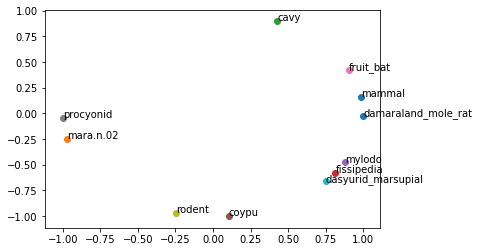

In [92]:
mammal = wordnet.synset("mammal.n.01")
cls = Poincarre_Embeddings(2000, 0.01, 4, mammal, 2)
embeddings = cls.train()
cls.plot_(embeddings)